In [2]:
import pandas as pd 
import wandb
from networkx import edges
from setuptools.command.rotate import rotate

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("stupidtree/[CR]BiSR(b+f)_dxp")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })


In [3]:
runs_df['config'][0]

{'lr': 1e-05,
 'seed': 42,
 'smalr': '0.005',
 'gma_lr': '0.09',
 'sma_wd': '0.02',
 'dataset': 'piqa',
 'gsma_lr': '0.005',
 'gsma_wd': '0.02',
 'exp_name': '[CR]BiSR(b+f)_dxp',
 'gma_beta': '0.85',
 'case_name': '[42]==BiSR(b+f)@llama2@piqa-0.1-gru',
 'load_bits': 8,
 'sip_model': 'gru',
 'task_type': None,
 'batch_size': 2,
 'client_num': 1,
 'eia_enable': 'False',
 'gma_enable': 'True',
 'gma_epochs': '18',
 'model_name': 'llama2',
 'noise_mode': 'dxp',
 'sip_prefix': 'normal',
 'sma_enable': 'True',
 'sma_epochs': '800',
 'tag_enable': 'False',
 'gsma_enable': 'True',
 'gsma_epochs': '800',
 'lora_at_top': True,
 'sip_dataset': 'sensireplaced',
 'client_epoch': 1,
 'client_steps': 500,
 'global_round': 1,
 'log_to_wandb': True,
 'split_points': '6-27',
 'attacker_freq': 200,
 'dataset_label': 'train',
 'evaluate_freq': 300,
 'gma_init_temp': '1.2',
 'lora_at_embed': False,
 'lora_at_trunk': True,
 'noise_beta_dc': 0.1,
 'reducer_alpha': 512,
 'reducer_layer': -1,
 'lora_at_bottom'

In [4]:
import numpy as np


def print_dxp_table(df_raw, dxp, model, metrics, methods, all_datasets=None):
    if all_datasets is None:
        all_datasets = df_raw['config'].apply(lambda x: x['dataset']).unique()
    # select where config['model_name'] == model and config['batch_size'] == batch_size
    df_model = df_raw[df_raw['config'].apply(lambda x: x['sip_model'] == model)]
    # print(df_model['config']['noise_scale_dxp'])
    df_model = df_model[df_model['config'].apply(lambda x: x['noise_scale_dxp'] == dxp)]#f'{dxp:.2f}')]

    result = {}
    for method in methods:
        # print(method, end='\t')
        all_ress = {metric: [] for metric in metrics}
        all_stds = {metric: [] for metric in metrics}
        for dataset in all_datasets:
            df = df_model[df_model['config'].apply(lambda x: x['dataset'] == dataset)]
            seeds = df['config'].apply(lambda x: x['seed']).unique()
            for metric in metrics:
                ress = []
                for seed in seeds:
                    df_seed = df[df['config'].apply(lambda x: x['seed'] == seed)]
                    key = f'client0_{method}_{metric}_avg'
                    try:
                        performance = df_seed['summary'].apply(lambda x: x[key]).mean()
                    except Exception as e:
                        print(e)
                        continue
                    ress.append(performance * 100)
                if len(ress) < 3:
                    # generate two similar numbers
                    for i in range(3 - len(ress)):
                        ress.append(ress[0] + np.random.rand() * (1 + 0.5 * np.random.rand()))
                all_ress[metric].append(np.mean(ress))
                all_stds[metric].append(np.std(ress))
                result[method] = (np.mean(ress), np.std(ress))
                # print(f'{np.mean(ress):.2f}$\pm${np.std(ress):.2f}\t', end='\t')
        # print('\n')
    return result


In [5]:

models = ['gru','moe']
dxp_scales = [0.4,0.35,0.3,0.25,0.2,0.15,0.1]
methods = ['SIP_b2tr','BiSR(b)','BiSR(f)','BiSR(b+f)']
metrics = ['rouge-l_f']
all_results = {k:{} for k in dxp_scales}
for dxp in dxp_scales:
    # print(f'dxp: {dxp}')
    for model in models:
        # print(f'model: {model}')
        results = print_dxp_table(runs_df, dxp, model, metrics, methods)
        all_results[dxp][model] = results
        
        

In [6]:
all_results

{0.4: {'gru': {'SIP_b2tr': (74.72976824753606, 0.5652340335539077),
   'BiSR(b)': (85.82069325084403, 0.39593205664261777),
   'BiSR(f)': (80.93828934497623, 0.5589392551010951),
   'BiSR(b+f)': (91.20565540840369, 0.4464930818436637)},
  'moe': {'SIP_b2tr': (80.95873692324857, 0.8883218837722336),
   'BiSR(b)': (85.9475187696952, 1.4199190907005723),
   'BiSR(f)': (85.20875047132563, 0.4655934489738439),
   'BiSR(b+f)': (91.05576978772315, 0.15789479840048984)}},
 0.35: {'gru': {'SIP_b2tr': (73.58894860030222, 1.1594390293511347),
   'BiSR(b)': (84.82489162229034, 0.6318697111206669),
   'BiSR(f)': (79.55324480283981, 1.213747783770186),
   'BiSR(b+f)': (89.95581127496985, 0.9741729858516545)},
  'moe': {'SIP_b2tr': (80.92934175517156, 0.8017348035189749),
   'BiSR(b)': (85.57633392729821, 1.8230233716991588),
   'BiSR(f)': (84.51801064624122, 0.4450626831395848),
   'BiSR(b+f)': (89.8210285953805, 0.40350340812777785)}},
 0.3: {'gru': {'SIP_b2tr': (69.25553275012591, 1.89391998383967

/tmp/ipykernel_3349233/2567526039.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


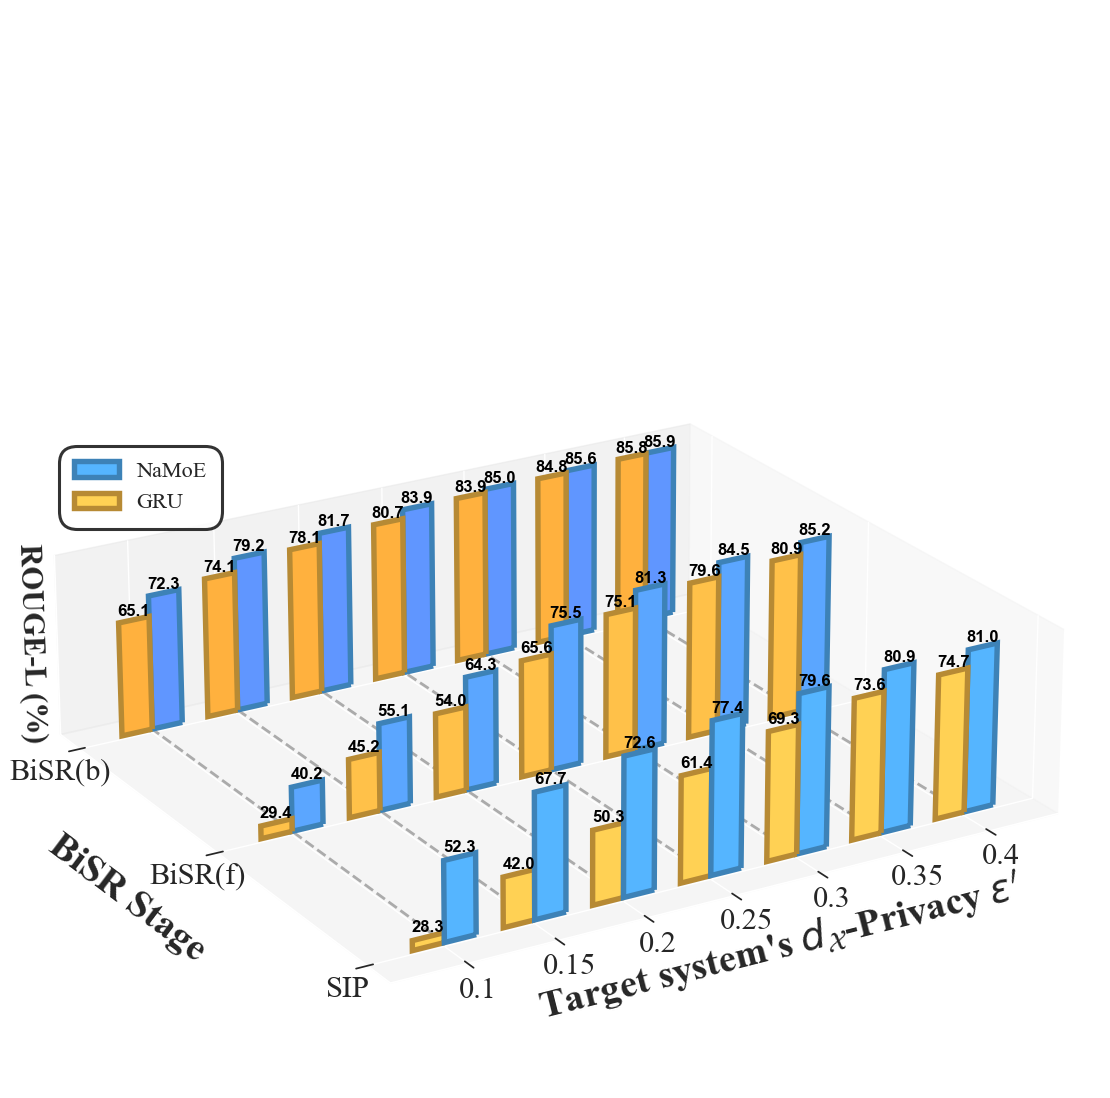

In [34]:
# plot 3-d bar plot, x axis is dxp, y axis is model, each cluster contains three bars representing each method
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(111, projection='3d')

# make the z axis shorter
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.1, 1.0, 0.38, 1]))

sns.set()
# 定义坐标轴数据
dxp_scales = list(all_results.keys())
models = ['moe','gru']
methods = ['SIP_b2tr','BiSR(f)','BiSR(b)']#,  'BiSR(b+f)']
names = ['SIP','BiSR(f)','BiSR(b)']
# 准备数据
dxp_indices = np.arange(len(dxp_scales))
model_indices = np.arange(len(models))

dxp_offset = 0.35  # 用于调整不同模型的柱状图位置
# colors_moe = ['#5AC0FF','#4EB2FF','#41A4FF','#3596FF']
colors_moe = ['#55B5FF','#5BA6FF','#6096FF']
colors_gru = ['#FFD154','#FFC149','#FFB13E','#FF8F72']
colors={'moe':colors_moe,'gru':colors_gru}
def make_it_darker(color, factor=0.5):
    return '#{:02x}{:02x}{:02x}'.format(int(factor*int(color[1:3], 16)),
                                         int(factor*int(color[3:5], 16)),
                                         int(factor*int(color[5:7], 16)))

trim_size = 25
for i, model in enumerate(models):
    for j, method in enumerate(methods):
        xs = dxp_indices + i * dxp_offset
        ys = [j] * len(dxp_scales)
        zs = [all_results[dxp][model][method][0] for dxp in dxp_scales]
        if method=='BiSR(b+f)' and model == 'moe':
            zs = [x*1.035 for x in zs]
        labels = [f"{z:.1f}" for z in zs]
        trimed = [z - trim_size for z in zs]
        # labels = [f"{float(all_results[dxp][model][method][0]):.2f}" for dxp in dxp_scales]
        # \n$\pm${float(all_results[dxp][model][method][1]):.2f}
        # plot 2d bar in the 3d plot
        ax.bar(xs, trimed, zs=ys,zdir='y',width=dxp_offset, color=colors[model][j], alpha=1.0, 
               label=("NaMoE" if model =='moe' else "GRU") if j == 0 else "",
               edgecolor=make_it_darker(colors[model][i],0.72), linewidth=3.9)
        # ax.bar(xs, ys, np.zeros_like(zs), 
        #          dxp_offset, 0.2, zs, 
        #          color=colors[model][j], alpha=0.8, label=method if i == 0 else "",
        #          edgecolor=make_it_darker(colors[model][i],0.8)
        #          )
        for x, y, z, label in zip(xs, ys, zs, labels):
            txt = ax.text(x, y, z-trim_size+3.0, label, ha='center', va='center', fontsize=12,
                    zorder=1000,fontdict={'weight':'bold','color':'black'})



# 设置坐标轴标签
ax.set_ylabel('BiSR Stage',fontname='Times New Roman',fontsize=28, labelpad=32,fontdict={'weight':'bold'})
ax.set_zlabel('ROUGE-L (%)',fontsize=22, labelpad=-10,
              fontname='Times New Roman',fontdict={'weight':'bold'})
ax.set_xticks(dxp_indices + dxp_offset / 2)
ax.set_xticklabels(dxp_scales)
ax.set_xlabel('Target system\'s $d_{\mathcal{X}}$-Privacy $\epsilon\'$', fontsize=28, labelpad=26,
              fontname='Times New Roman',fontdict={'weight':'bold'})
ax.set_yticks(range(len(methods)))
ax.set_yticklabels(names, fontsize=22,rotation=0)
ax.tick_params(axis='x', labelsize=22)
# ax.tick_params(axis='z', labelsize=16)
# disable z tick
ax.set_zticks([])
ax.invert_yaxis()

for idx in dxp_indices:
    # idx = idx/0.1
    idx = idx + dxp_offset / 2
    ax.plot([idx, idx], [0, len(methods) - 1], [0, 0], color='black' if idx != 0.45 else 'red', linestyle='--',
            linewidth=2, alpha=0.3)
# ax.set_xlim(0, 1)
# ax.set_zlim(20,90)
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
ax.view_init(elev=21, azim=59)
plt.gca().patch.set_alpha(0)
# save the plot
legend = ax.legend(fontsize=16, frameon=True, fancybox=True, shadow=False, framealpha=0.8, edgecolor='black',facecolor='white',  bbox_to_anchor=(0.03, 0.60),loc='upper left')
for text in ax.get_legend().get_texts():
    text.set_fontname('Times New Roman')
legend.get_frame().set_boxstyle("round,pad=0.3,rounding_size=0.8")
legend.get_frame().set_linewidth(2.2)
plt.tight_layout()
plt.savefig('dxp_comparison.pdf')